# Benchmark Analysis: Baseline vs OVC

This notebook analyzes and compares the performance of baseline and OVC (Optimized Value Compression) sorting algorithms.

In [460]:
import re
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set matplotlib style
# plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use("custom_plt_sytle.mplstyle")
%matplotlib inline

## Parse Log Files

In [461]:
def parse_log_file(filepath):
    """Parse a benchmark log file and extract metrics."""
    with open(filepath, 'r') as f:
        content = f.read()

    # Extract OVC status
    ovc_match = re.search(r'OVC enabled: (\w+)', content)
    ovc_enabled = ovc_match.group(1) == 'true' if ovc_match else False
    
    # Extract estimated CSV size
    csv_size_match = re.search(r'Estimated data size: ([\d.]+) MB', content)
    csv_size_gb = float(csv_size_match.group(1)) / 1024 if csv_size_match else 0

    # Find all policy sections (using Run 1/3 for consistency)
    policy_pattern = r'Running benchmark for policy: ([\w_.]+).*?Parameters: .*?Run Size: ([\d.]+) MB.*?Run 1/3:.*?Generated (\d+) runs in (\d+) ms.*?Merging \d+ runs.*?Merge phase took (\d+) ms.*?SortStats:.*?\(R\) I/O stats: I/O Stats: Read Ops: (\d+), Read Bytes: (\d+), Write Ops: (\d+), Write Bytes: (\d+).*?\(M\) I/O stats: I/O Stats: Read Ops: (\d+), Read Bytes: (\d+), Write Ops: (\d+), Write Bytes: (\d+).*?Read amplification factor: ([\d.]+)x.*?Imbalance factor \(max/min\): ([\d.]+)x'

    results = []
    for match in re.finditer(policy_pattern, content, re.DOTALL):
        policy_name = match.group(1)
        run_size_mb = float(match.group(2))
        num_runs = int(match.group(3))
        run_gen_time_ms = int(match.group(4))
        merge_time_ms = int(match.group(5))

        # Run generation I/O
        rg_read_ops = int(match.group(6))
        rg_read_bytes = int(match.group(7))
        rg_write_ops = int(match.group(8))
        rg_write_bytes = int(match.group(9))

        # Merge I/O
        m_read_ops = int(match.group(10))
        m_read_bytes = int(match.group(11))
        m_write_ops = int(match.group(12))
        m_write_bytes = int(match.group(13))

        read_amp = float(match.group(14))
        imbalance = float(match.group(15))

        # Total I/O in GB
        total_read_gb = (rg_read_bytes + m_read_bytes) / (1024**3)
        total_write_gb = (rg_write_bytes + m_write_bytes) / (1024**3)
        total_io_gb = total_read_gb + total_write_gb
        
        # Run generation read is just CSV read
        csv_read_gb = rg_read_bytes / (1024**3)
        m_read_gb = m_read_bytes / (1024**3)

        results.append({
            'policy': policy_name,
            'run_size_mb': run_size_mb,
            'num_runs': num_runs,
            'run_gen_time_s': run_gen_time_ms / 1000,
            'merge_time_s': merge_time_ms / 1000,
            'total_time_s': (run_gen_time_ms + merge_time_ms) / 1000,
            'read_amp': read_amp,
            'imbalance': imbalance,
            'total_io_gb': total_io_gb,
            'total_read_gb': total_read_gb,
            'total_write_gb': total_write_gb,
            'csv_read_gb': csv_read_gb,
            'm_read_gb': m_read_gb,
            'rg_write_gb': rg_write_bytes / (1024**3),
            'm_write_gb': m_write_bytes / (1024**3),
        })

    return ovc_enabled, results

In [462]:
# Parse both log files
baseline_log = 'lineitem_2025-10-02_23-22-48_baseline.log'
ovc_log = 'lineitem_2025-10-02_23-22-48_ovc.log'

print(f"Parsing {baseline_log}...")
ovc_status, baseline_results = parse_log_file(baseline_log)
print(f"  Found {len(baseline_results)} policy configurations")
print(f"  OVC enabled: {ovc_status}")

print(f"\nParsing {ovc_log}...")
ovc_status, ovc_results = parse_log_file(ovc_log)
print(f"  Found {len(ovc_results)} policy configurations")
print(f"  OVC enabled: {ovc_status}")

Parsing lineitem_2025-10-02_23-22-48_baseline.log...
  Found 5 policy configurations
  OVC enabled: False

Parsing lineitem_2025-10-02_23-22-48_ovc.log...
  Found 5 policy configurations
  OVC enabled: True


## Summary Table

In [463]:
import pandas as pd

# Create comparison dataframe
comparison_data = []
for b, o in zip(baseline_results, ovc_results):
    speedup = b['total_time_s'] / o['total_time_s']
    comparison_data.append({
        'Policy': b['policy'],
        'Run Size (MB)': b['run_size_mb'],
        'Baseline RunGen (s)': b['run_gen_time_s'],
        'Baseline Merge (s)': b['merge_time_s'],
        'Baseline Total (s)': b['total_time_s'],
        'OVC RunGen (s)': o['run_gen_time_s'],
        'OVC Merge (s)': o['merge_time_s'],
        'OVC Total (s)': o['total_time_s'],
        'Speedup': speedup,
        'Baseline I/O (GB)': b['total_io_gb'],
        'OVC I/O (GB)': o['total_io_gb'],
        'I/O Reduction (%)': (1 - o['total_io_gb'] / b['total_io_gb']) * 100
    })

df = pd.DataFrame(comparison_data)
df

,Policy,Run Size (MB),Baseline RunGen (s),Baseline Merge (s),Baseline Total (s),OVC RunGen (s),OVC Merge (s),OVC Total (s),Speedup,Baseline I/O (GB),OVC I/O (GB),I/O Reduction (%)
0,Log_0.0,12.74,732.916,489.396,1222.312,688.288,332.070,1020.358,1.197925,1010.658537,804.327394,20.415515
1,Log_0.25,38.14,770.013,474.938,1244.951,718.048,298.389,1016.437,1.224819,979.809783,763.677294,22.058617
2,Log_0.5,114.20,746.396,434.603,1180.999,758.259,264.232,1022.491,1.155021,969.520658,742.199527,23.446755
3,Log_0.75,341.97,782.968,405.764,1188.732,776.868,238.792,1015.660,1.170403,966.089873,727.519578,24.694420
4,Log_1.0,1024.00,830.284,399.413,1229.697,853.165,230.211,1083.376,1.135060,964.944976,715.497020,25.851003


## Plot 1: Sort Time with Breakdown

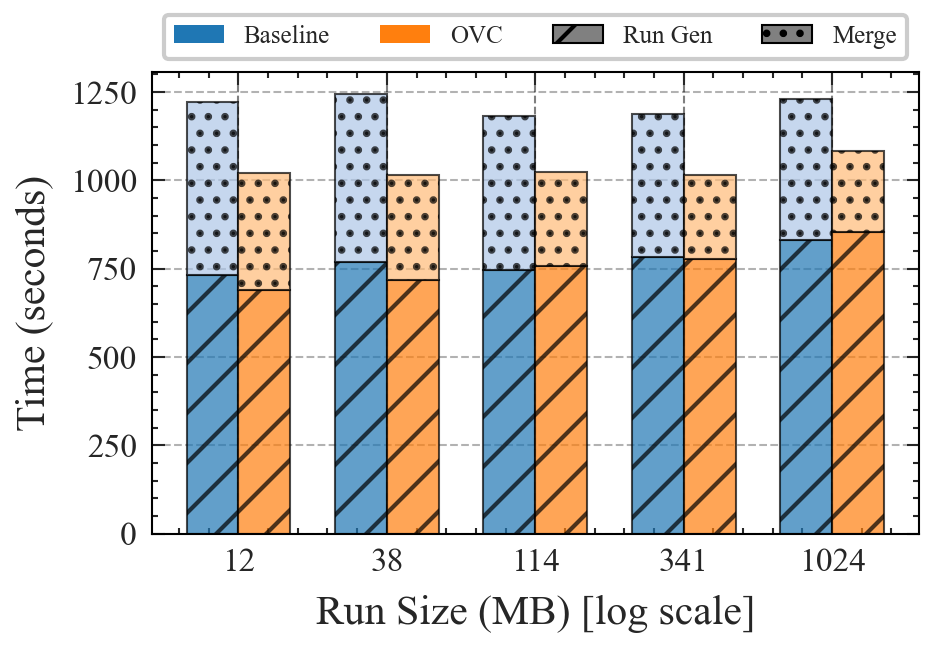

In [464]:
# Extract data for plotting
from matplotlib.patches import Patch

baseline_run_sizes = [r['run_size_mb'] for r in baseline_results]
baseline_run_gen = [r['run_gen_time_s'] for r in baseline_results]
baseline_merge = [r['merge_time_s'] for r in baseline_results]
baseline_total = [r['total_time_s'] for r in baseline_results]

ovc_run_sizes = [r['run_size_mb'] for r in ovc_results]
ovc_run_gen = [r['run_gen_time_s'] for r in ovc_results]
ovc_merge = [r['merge_time_s'] for r in ovc_results]
ovc_total = [r['total_time_s'] for r in ovc_results]

# Log scale for x-axis
log_baseline_sizes = np.log10(baseline_run_sizes)
log_ovc_sizes = np.log10(ovc_run_sizes)

# Create stacked bar chart with patterns
fig, ax = plt.subplots()

x = np.arange(len(baseline_run_sizes))
width = 0.35

# Baseline stacked bars with patterns
p1 = ax.bar(x - width/2, baseline_run_gen, width,
            color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='//')
p2 = ax.bar(x - width/2, baseline_merge, width, bottom=baseline_run_gen, 
            color='#aec7e8', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='...')

# OVC stacked bars with patterns
p3 = ax.bar(x + width/2, ovc_run_gen, width,
            color='#ff7f0e', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='//')
p4 = ax.bar(x + width/2, ovc_merge, width, bottom=ovc_run_gen, 
            color='#ffbb78', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='...')

ax.set_xlabel('Run Size (MB) [log scale]')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(s)}' for s in baseline_run_sizes])

# Create custom legend with color indicators and pattern labels
legend_elements = [
    Patch(facecolor='#1f77b4', label='Baseline'),
    Patch(facecolor='#ff7f0e', label='OVC'),
    Patch(facecolor='gray', edgecolor='black', linewidth=0.5, hatch='//', label='Run Gen'),
    Patch(facecolor='gray', edgecolor='black', linewidth=0.5, hatch='...', label='Merge'),
]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
ax.grid(True, alpha=0.3, axis='y')

# plt.tight_layout()
plt.savefig('run_length_sort_time.svg', dpi=300)
plt.savefig('run_length_sort_time.png', dpi=300)
plt.show()

## Plot 1.1: Memory Usage with Breakdown

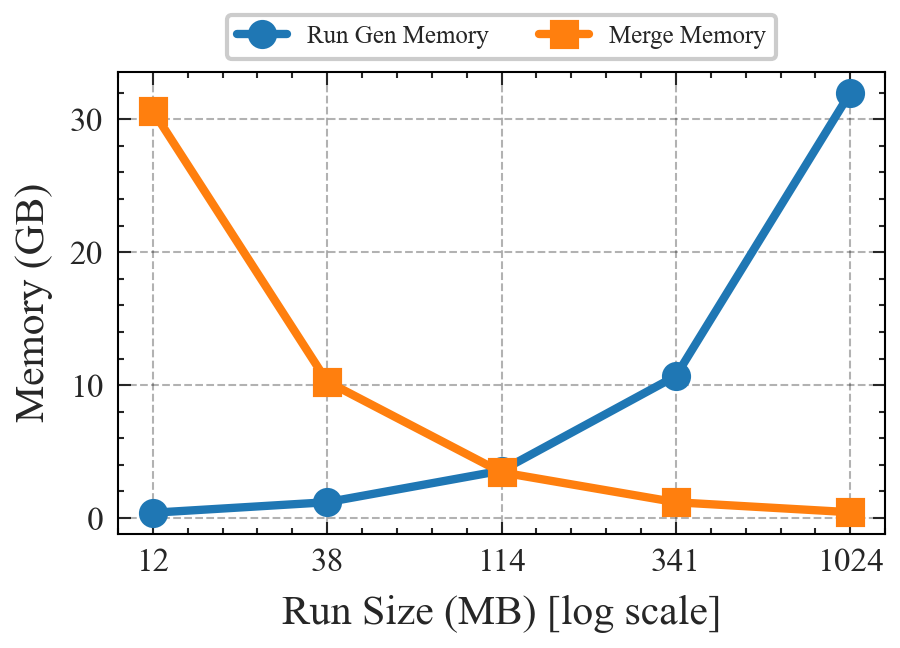

In [465]:
# Constants
THREADS = 32
PAGE_SIZE_KB = 64
PAGE_SIZE_MB = PAGE_SIZE_KB / 1024

# Calculate memory usage (same for baseline and OVC)
num_runs = [r['num_runs'] for r in baseline_results]
run_sizes = baseline_run_sizes

# Memory during run generation (GB)
run_gen_mem = [r * THREADS / 1024 for r in run_sizes]

# Memory during merge (GB)
merge_mem = [n * PAGE_SIZE_MB * THREADS / 1024 for n in num_runs]

# Create line plot for memory
fig, ax = plt.subplots()

x = np.arange(len(run_sizes))

# Two lines: Run Gen and Merge
ax.plot(x, run_gen_mem, 'o-', linewidth=2, markersize=6,
        label='Run Gen Memory', color='#1f77b4')
ax.plot(x, merge_mem, 's-', linewidth=2, markersize=6,
        label='Merge Memory', color='#ff7f0e')

# Annotate number of runs for merge memory points
# for i in x:
#     ax.annotate(f'{num_runs[i]:,}', 
#                 xy=(i, merge_mem[i]), 
#                 xytext=(0, 5), textcoords='offset points',
#                 ha='center', fontsize=7, color='#ff7f0e')

ax.set_xlabel('Run Size (MB) [log scale]')
ax.set_ylabel('Memory (GB)')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(s)}' for s in run_sizes])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
ax.grid(True, alpha=0.3)

# plt.tight_layout()
plt.savefig('run_length_memory.svg', dpi=300)
plt.savefig('run_length_memory.png', dpi=300)
plt.show()

## Plot 1.3: I/O Volume

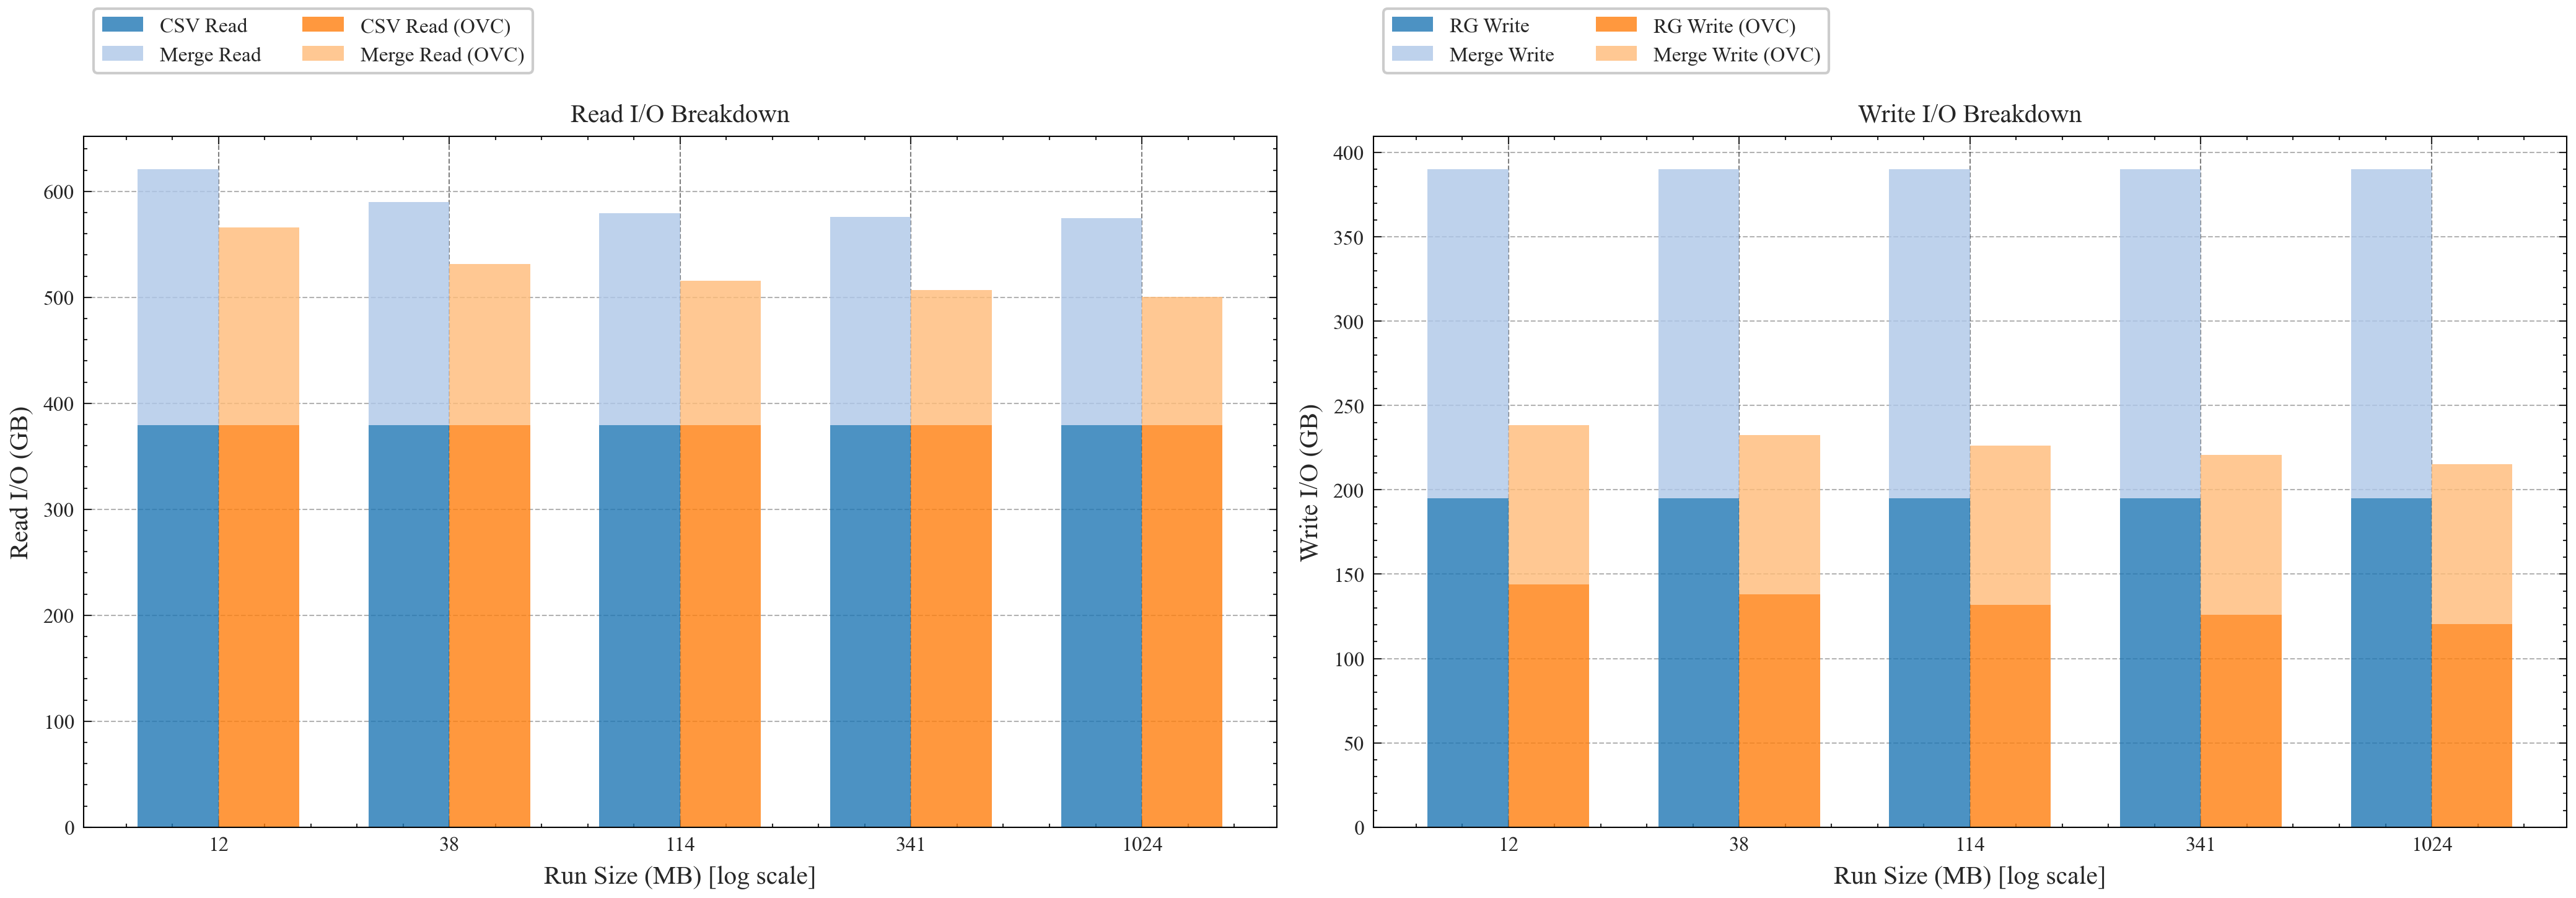

In [466]:
# Extract I/O data from baseline and OVC results
baseline_csv_read = [r['csv_read_gb'] for r in baseline_results]
baseline_m_read = [r['m_read_gb'] for r in baseline_results]
baseline_rg_write = [r['rg_write_gb'] for r in baseline_results]
baseline_m_write = [r['m_write_gb'] for r in baseline_results]

ovc_csv_read = [r['csv_read_gb'] for r in ovc_results]
ovc_m_read = [r['m_read_gb'] for r in ovc_results]
ovc_rg_write = [r['rg_write_gb'] for r in ovc_results]
ovc_m_write = [r['m_write_gb'] for r in ovc_results]

# Create stacked bar chart for I/O Volume - grouped by Read/Write
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(baseline_run_sizes))
width = 0.35

# Left plot: READ I/O breakdown
# Baseline reads
ax1.bar(x - width/2, baseline_csv_read, width, 
        label='CSV Read', color='#1f77b4', alpha=0.8)
ax1.bar(x - width/2, baseline_m_read, width, bottom=baseline_csv_read,
        label='Merge Read', color='#aec7e8', alpha=0.8)

# OVC reads
ax1.bar(x + width/2, ovc_csv_read, width,
        label='CSV Read (OVC)', color='#ff7f0e', alpha=0.8)
ax1.bar(x + width/2, ovc_m_read, width, bottom=ovc_csv_read,
        label='Merge Read (OVC)', color='#ffbb78', alpha=0.8)

ax1.set_xlabel('Run Size (MB) [log scale]')
ax1.set_ylabel('Read I/O (GB)')
ax1.set_title('Read I/O Breakdown')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{int(s)}' for s in baseline_run_sizes])
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.20), fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3, axis='y')

# Right plot: WRITE I/O breakdown
# Baseline writes
ax2.bar(x - width/2, baseline_rg_write, width,
        label='RG Write', color='#1f77b4', alpha=0.8)
ax2.bar(x - width/2, baseline_m_write, width, bottom=baseline_rg_write,
        label='Merge Write', color='#aec7e8', alpha=0.8)

# OVC writes
ax2.bar(x + width/2, ovc_rg_write, width,
        label='RG Write (OVC)', color='#ff7f0e', alpha=0.8)
ax2.bar(x + width/2, ovc_m_write, width, bottom=ovc_rg_write,
        label='Merge Write (OVC)', color='#ffbb78', alpha=0.8)

ax2.set_xlabel('Run Size (MB) [log scale]')
ax2.set_ylabel('Write I/O (GB)')
ax2.set_title('Write I/O Breakdown')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{int(s)}' for s in baseline_run_sizes])
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1.20), fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('run_length_io_volume.svg', dpi=300)
plt.show()

## Plot 1.4: I/O Bandwidth

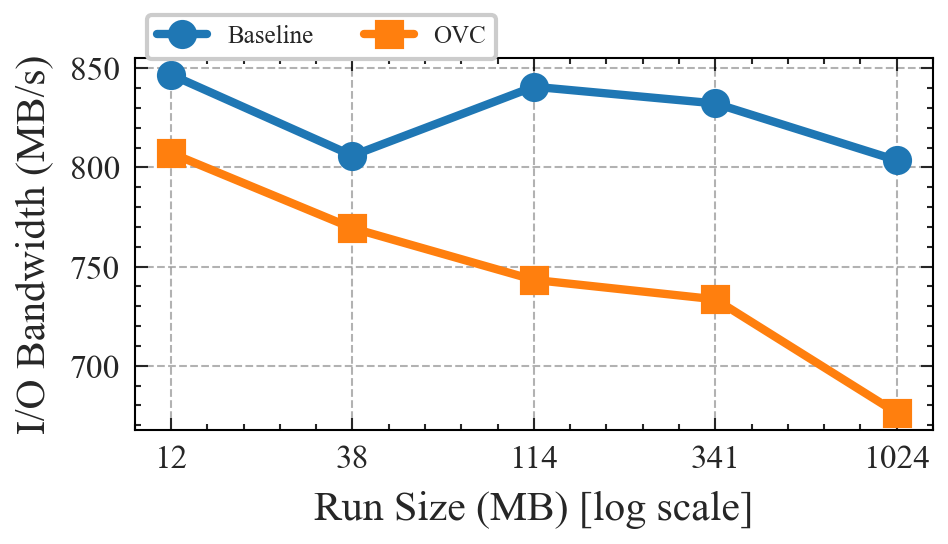

In [467]:
# Calculate I/O bandwidth
baseline_bandwidth_mbs = [(r['total_io_gb'] * 1024) / r['total_time_s'] for r in baseline_results]
ovc_bandwidth_mbs = [(r['total_io_gb'] * 1024) / r['total_time_s'] for r in ovc_results]

# Create I/O Bandwidth plot
fig, ax = plt.subplots()

x = np.arange(len(baseline_run_sizes))

# Plot I/O Bandwidth
ax.plot(x, baseline_bandwidth_mbs, 'o-', linewidth=2, markersize=6,
         label='Baseline', color='#1f77b4')
ax.plot(x, ovc_bandwidth_mbs, 's-', linewidth=2, markersize=6,
         label='OVC', color='#ff7f0e')

ax.set_xlabel('Run Size (MB) [log scale]')
ax.set_ylabel('I/O Bandwidth (MB/s)')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(s)}' for s in baseline_run_sizes])
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('run_length_io_bandwidth.svg', dpi=300)
plt.show()

## Plot 1.5: Combined I/O Volume

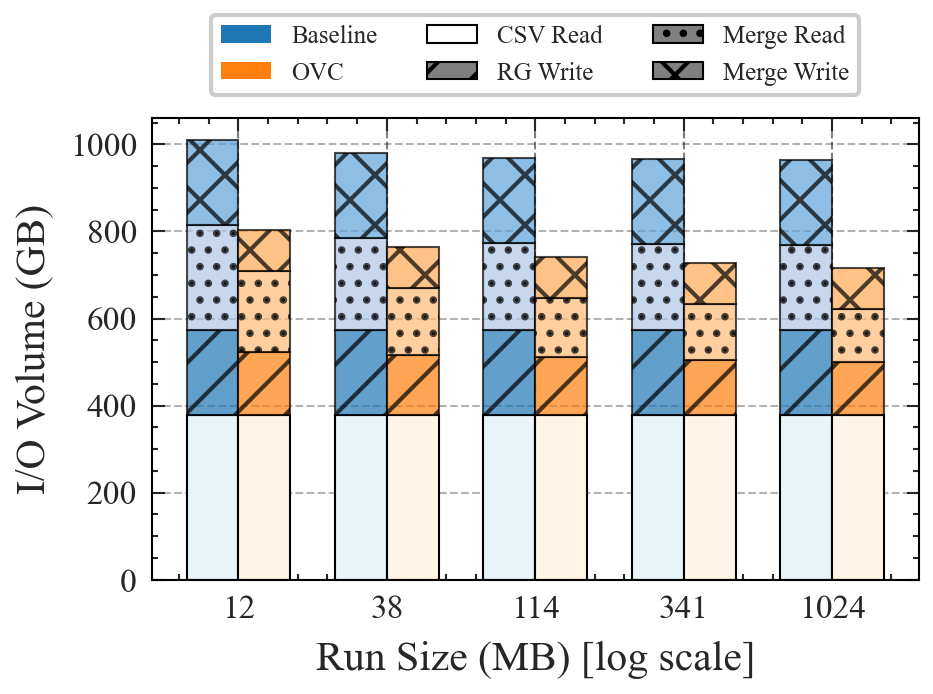

In [468]:
# Create single stacked bar chart with 4 sections and patterns for differentiation
from matplotlib.patches import Patch

fig, ax = plt.subplots()

x = np.arange(len(baseline_run_sizes))
width = 0.35

# Baseline stacked bars (4 sections with patterns)
p1 = ax.bar(x - width/2, baseline_csv_read, width, 
            color='#e8f4f8', edgecolor='black', linewidth=0.5)
p2 = ax.bar(x - width/2, baseline_rg_write, width, bottom=baseline_csv_read,
            color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='//')
baseline_base2 = [csv + rg for csv, rg in zip(baseline_csv_read, baseline_rg_write)]
p3 = ax.bar(x - width/2, baseline_m_read, width, bottom=baseline_base2,
            color='#aec7e8', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='...')
baseline_base3 = [b + m for b, m in zip(baseline_base2, baseline_m_read)]
p4 = ax.bar(x - width/2, baseline_m_write, width, bottom=baseline_base3,
            color='#5fa3d9', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='xx')

# OVC stacked bars (4 sections with patterns)
p5 = ax.bar(x + width/2, ovc_csv_read, width,
            color='#fff4e6', edgecolor='black', linewidth=0.5)
p6 = ax.bar(x + width/2, ovc_rg_write, width, bottom=ovc_csv_read,
            color='#ff7f0e', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='//')
ovc_base2 = [csv + rg for csv, rg in zip(ovc_csv_read, ovc_rg_write)]
p7 = ax.bar(x + width/2, ovc_m_read, width, bottom=ovc_base2,
            color='#ffbb78', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='...')
ovc_base3 = [b + m for b, m in zip(ovc_base2, ovc_m_read)]
p8 = ax.bar(x + width/2, ovc_m_write, width, bottom=ovc_base3,
            color='#ffaa55', alpha=0.7, edgecolor='black', linewidth=0.5, hatch='xx')

ax.set_xlabel('Run Size (MB) [log scale]')
ax.set_ylabel('I/O Volume (GB)')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(s)}' for s in baseline_run_sizes])

# Create custom legend with color indicators and pattern labels
legend_elements = [
    Patch(facecolor='#1f77b4', label='Baseline'),
    Patch(facecolor='#ff7f0e', label='OVC'),
    Patch(facecolor='white', edgecolor='black', linewidth=0.5, label='CSV Read'),
    Patch(facecolor='gray', edgecolor='black', linewidth=0.5, hatch='//', label='RG Write'),
    Patch(facecolor='gray', edgecolor='black', linewidth=0.5, hatch='...', label='Merge Read'),
    Patch(facecolor='gray', edgecolor='black', linewidth=0.5, hatch='xx', label='Merge Write'),
]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
ax.grid(True, alpha=0.3, axis='y')

# plt.tight_layout()
plt.savefig('run_length_io_combined.svg', dpi=300)
plt.savefig('run_length_io_combined.png', dpi=300)
plt.show()

## Plot 2: Time vs Log(Run Length)

/tmp/ipykernel_484735/2083935519.py:25: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_484735/2083935519.py:25: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
/home/rotaki/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rotaki/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


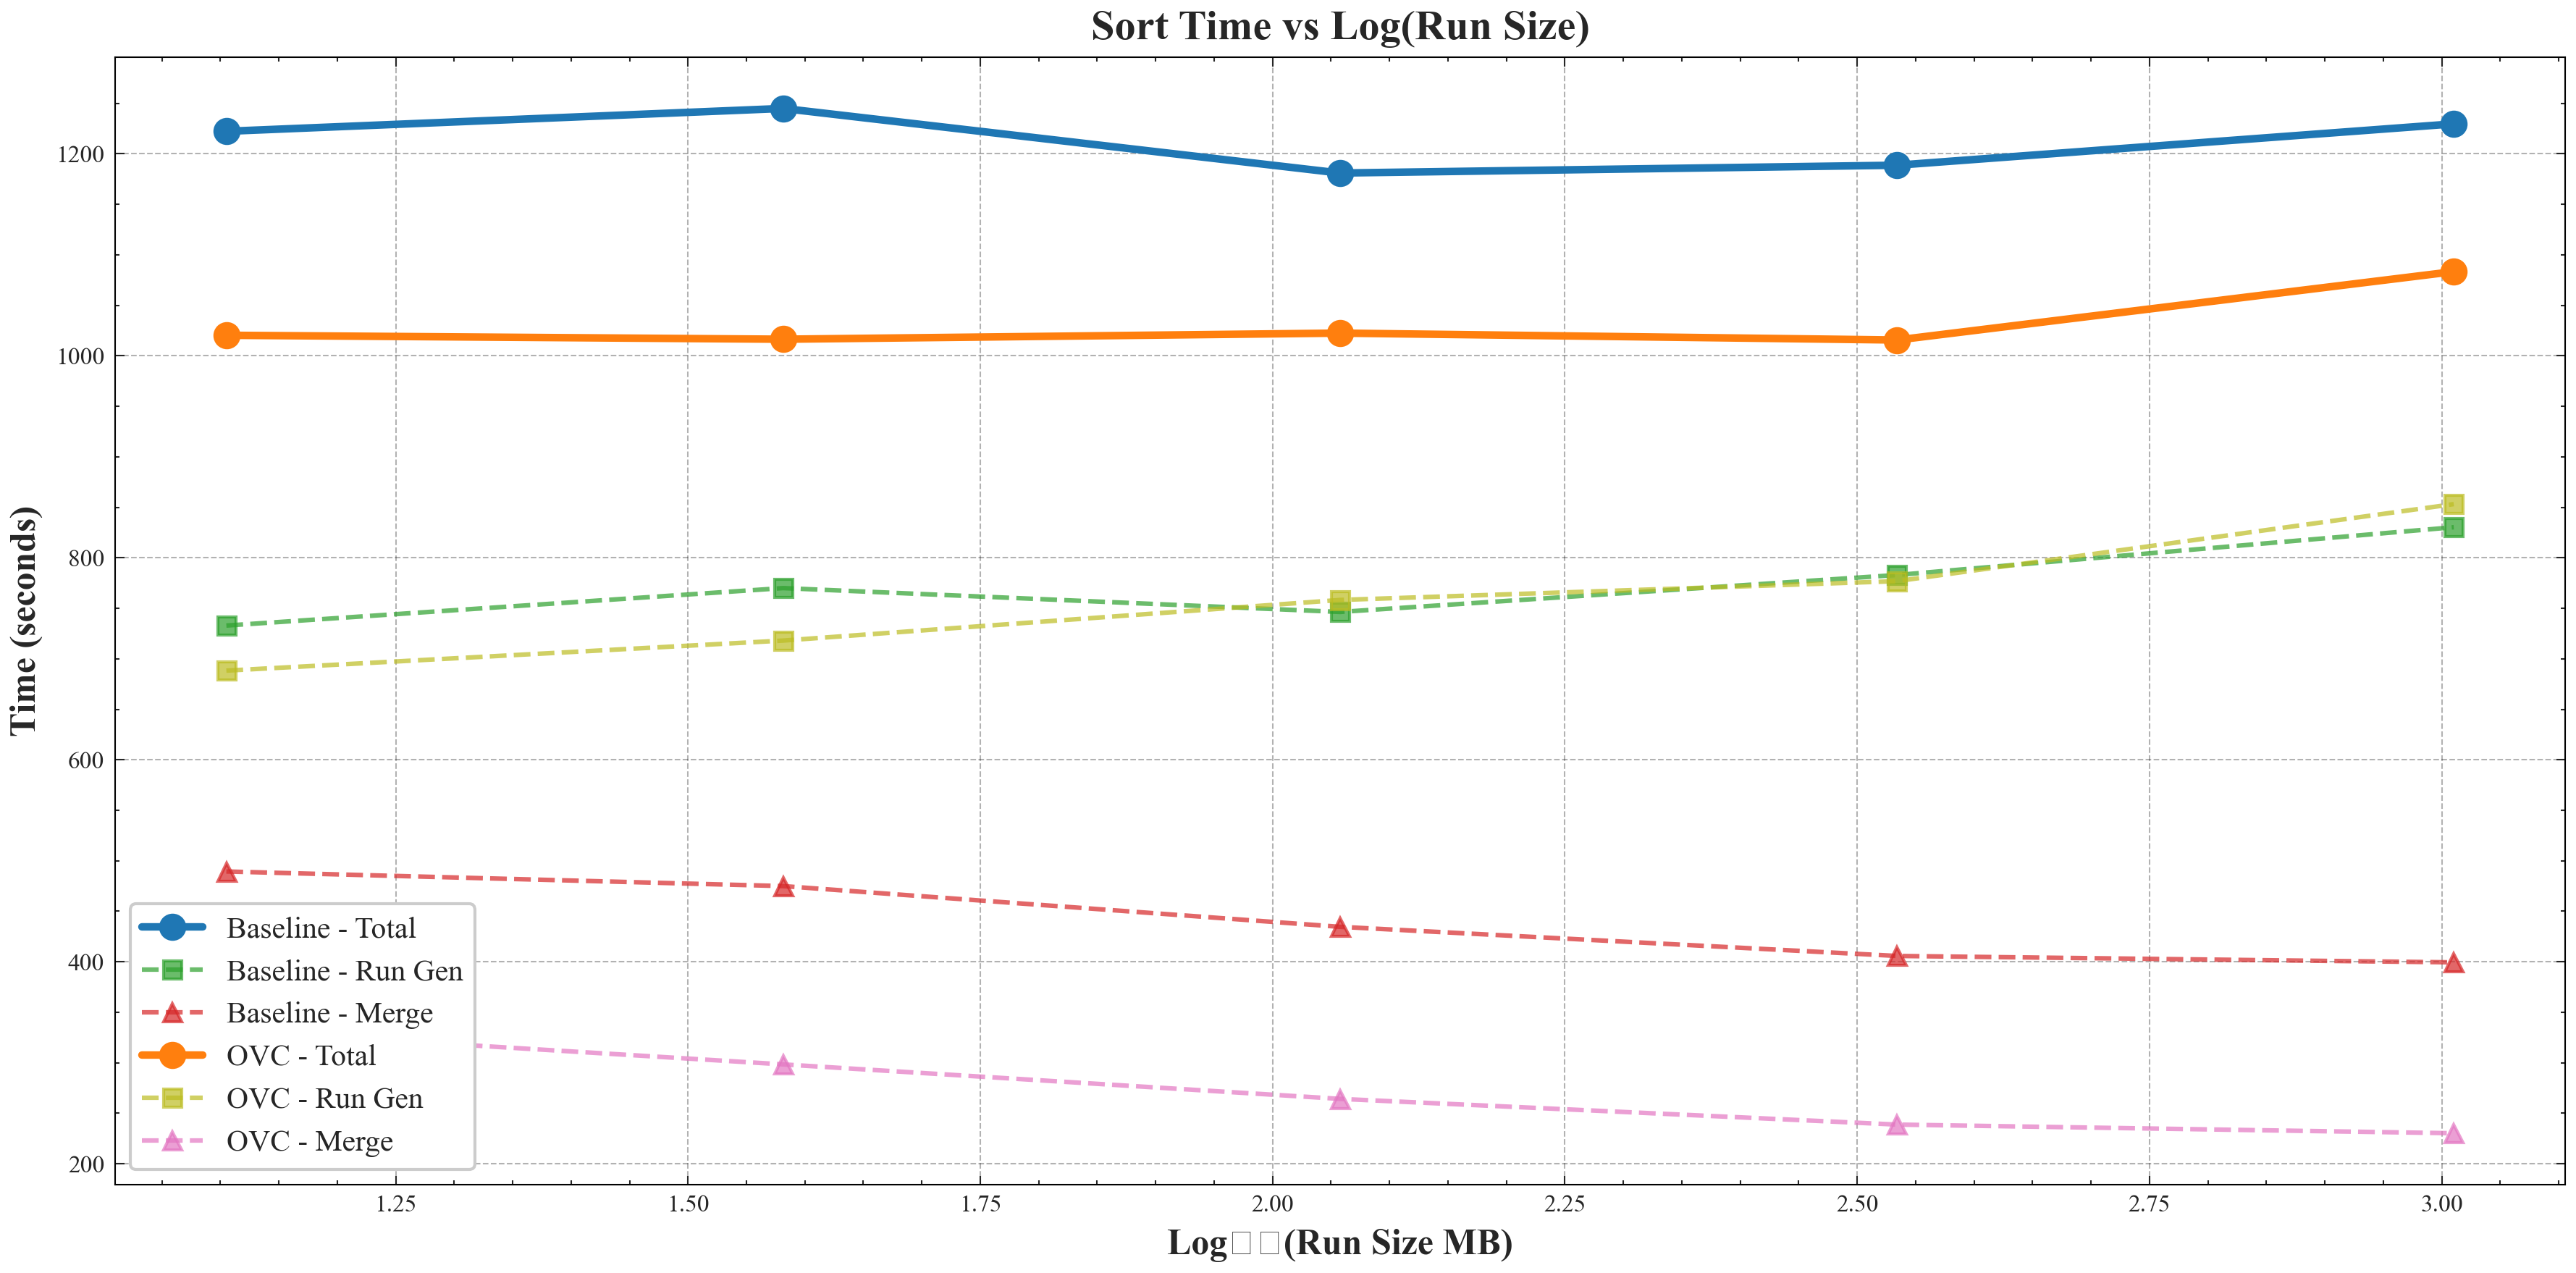

In [469]:
fig, ax = plt.subplots(figsize=(12, 6))

# Baseline
ax.plot(log_baseline_sizes, baseline_total, 'o-', linewidth=2.5, markersize=8,
        label='Baseline - Total', color='#1f77b4')
ax.plot(log_baseline_sizes, baseline_run_gen, 's--', linewidth=1.5, markersize=6,
        label='Baseline - Run Gen', color='#2ca02c', alpha=0.7)
ax.plot(log_baseline_sizes, baseline_merge, '^--', linewidth=1.5, markersize=6,
        label='Baseline - Merge', color='#d62728', alpha=0.7)

# OVC
ax.plot(log_ovc_sizes, ovc_total, 'o-', linewidth=2.5, markersize=8,
        label='OVC - Total', color='#ff7f0e')
ax.plot(log_ovc_sizes, ovc_run_gen, 's--', linewidth=1.5, markersize=6,
        label='OVC - Run Gen', color='#bcbd22', alpha=0.7)
ax.plot(log_ovc_sizes, ovc_merge, '^--', linewidth=1.5, markersize=6,
        label='OVC - Merge', color='#e377c2', alpha=0.7)

ax.set_xlabel('Log₁₀(Run Size MB)', fontsize=12, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Sort Time vs Log(Run Size)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Plot 3: I/O and Imbalance Factor vs Log(Run Length)

/tmp/ipykernel_484735/3278723798.py:33: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_484735/3278723798.py:33: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()


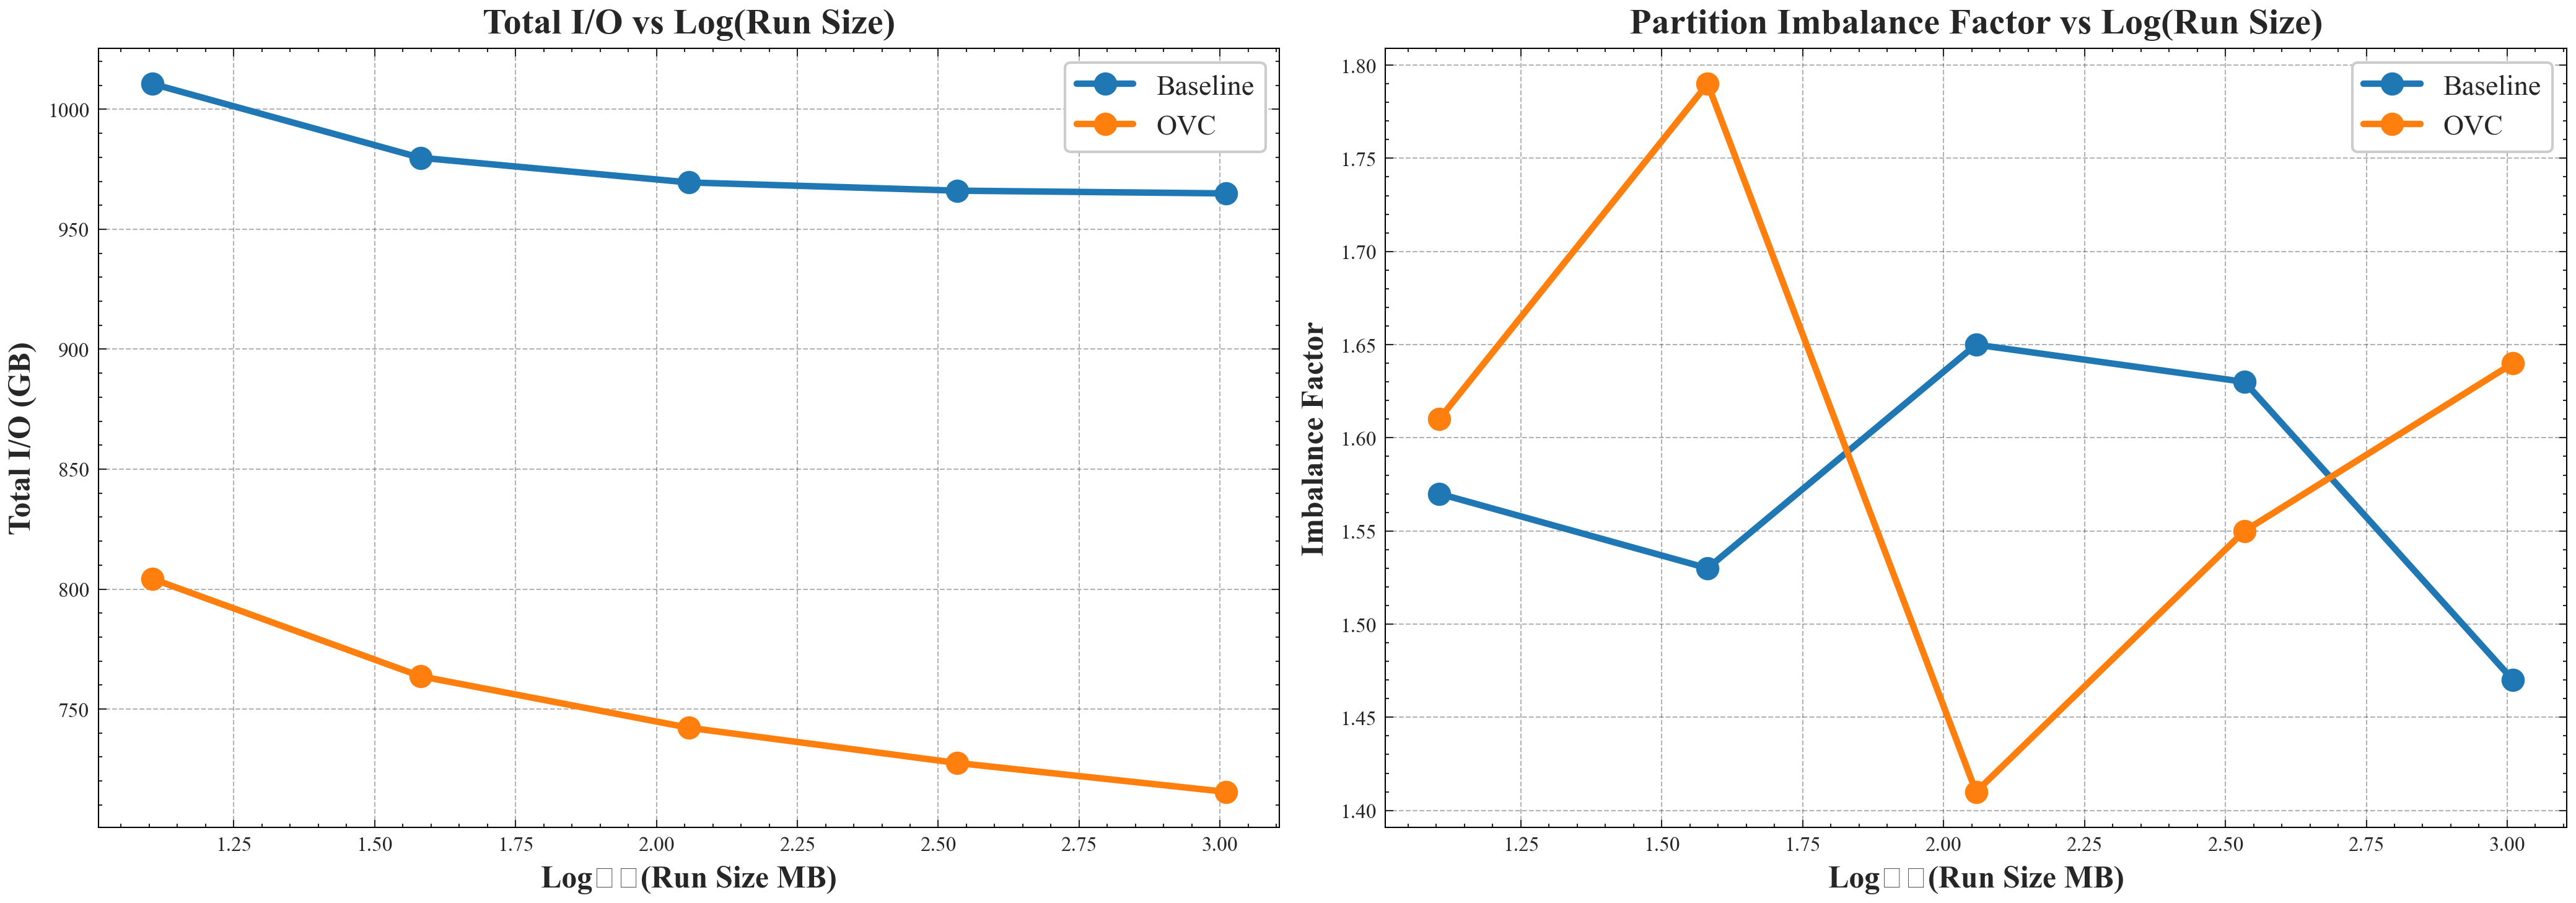

In [470]:
baseline_io = [r['total_io_gb'] for r in baseline_results]
baseline_imbalance = [r['imbalance'] for r in baseline_results]

ovc_io = [r['total_io_gb'] for r in ovc_results]
ovc_imbalance = [r['imbalance'] for r in ovc_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 3a: Total I/O
ax1.plot(log_baseline_sizes, baseline_io, 'o-', linewidth=2.5, markersize=8,
         label='Baseline', color='#1f77b4')
ax1.plot(log_ovc_sizes, ovc_io, 'o-', linewidth=2.5, markersize=8,
         label='OVC', color='#ff7f0e')

ax1.set_xlabel('Log₁₀(Run Size MB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total I/O (GB)', fontsize=12, fontweight='bold')
ax1.set_title('Total I/O vs Log(Run Size)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 3b: Imbalance Factor
ax2.plot(log_baseline_sizes, baseline_imbalance, 'o-', linewidth=2.5, markersize=8,
         label='Baseline', color='#1f77b4')
ax2.plot(log_ovc_sizes, ovc_imbalance, 'o-', linewidth=2.5, markersize=8,
         label='OVC', color='#ff7f0e')

ax2.set_xlabel('Log₁₀(Run Size MB)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Imbalance Factor', fontsize=12, fontweight='bold')
ax2.set_title('Partition Imbalance Factor vs Log(Run Size)', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Performance Improvements

In [471]:
# Calculate improvements
for b, o in zip(baseline_results, ovc_results):
    time_speedup = b['total_time_s'] / o['total_time_s']
    merge_speedup = b['merge_time_s'] / o['merge_time_s']
    io_reduction = (1 - o['total_io_gb'] / b['total_io_gb']) * 100
    
    print(f"Policy {b['policy']} (Run Size: {b['run_size_mb']:.1f} MB):")
    print(f"  Total Time Speedup: {time_speedup:.2f}x ({b['total_time_s']:.1f}s → {o['total_time_s']:.1f}s)")
    print(f"  Merge Phase Speedup: {merge_speedup:.2f}x ({b['merge_time_s']:.1f}s → {o['merge_time_s']:.1f}s)")
    print(f"  I/O Reduction: {io_reduction:.1f}% ({b['total_io_gb']:.1f}GB → {o['total_io_gb']:.1f}GB)")
    print()

# Observation
print("="*80)
print("KEY OBSERVATION: Run length does not significantly affect sorting time!")
print("="*80)

Policy Log_0.0 (Run Size: 12.7 MB):
  Total Time Speedup: 1.20x (1222.3s → 1020.4s)
  Merge Phase Speedup: 1.47x (489.4s → 332.1s)
  I/O Reduction: 20.4% (1010.7GB → 804.3GB)

Policy Log_0.25 (Run Size: 38.1 MB):
  Total Time Speedup: 1.22x (1245.0s → 1016.4s)
  Merge Phase Speedup: 1.59x (474.9s → 298.4s)
  I/O Reduction: 22.1% (979.8GB → 763.7GB)

Policy Log_0.5 (Run Size: 114.2 MB):
  Total Time Speedup: 1.16x (1181.0s → 1022.5s)
  Merge Phase Speedup: 1.64x (434.6s → 264.2s)
  I/O Reduction: 23.4% (969.5GB → 742.2GB)

Policy Log_0.75 (Run Size: 342.0 MB):
  Total Time Speedup: 1.17x (1188.7s → 1015.7s)
  Merge Phase Speedup: 1.70x (405.8s → 238.8s)
  I/O Reduction: 24.7% (966.1GB → 727.5GB)

Policy Log_1.0 (Run Size: 1024.0 MB):
  Total Time Speedup: 1.14x (1229.7s → 1083.4s)
  Merge Phase Speedup: 1.73x (399.4s → 230.2s)
  I/O Reduction: 25.9% (964.9GB → 715.5GB)

KEY OBSERVATION: Run length does not significantly affect sorting time!


In [472]:
# Find optimal run size (minimum peak memory)
baseline_min_idx = np.argmin([m['peak_memory_gb'] for m in baseline_memory])
ovc_min_idx = np.argmin([m['peak_memory_gb'] for m in ovc_memory])

print("="*80)
print("OPTIMAL RUN SIZE RECOMMENDATION")
print("="*80)
print("\nBaseline:")
print(f"  Optimal Policy: {baseline_memory[baseline_min_idx]['policy']}")
print(f"  Run Size: {baseline_memory[baseline_min_idx]['run_size_mb']:.2f} MB")
print(f"  Number of Runs: {baseline_memory[baseline_min_idx]['num_runs']}")
print(f"  Run Gen Memory: {baseline_memory[baseline_min_idx]['mem_run_gen_mb'] / 1024:.2f} GB")
print(f"  Merge Memory: {baseline_memory[baseline_min_idx]['mem_merge_mb'] / 1024:.2f} GB")
print(f"  Peak Memory: {baseline_memory[baseline_min_idx]['peak_memory_gb']:.2f} GB")
print(f"  Sort Time: {baseline_results[baseline_min_idx]['total_time_s']:.1f} s")

print("\nOVC:")
print(f"  Optimal Policy: {ovc_memory[ovc_min_idx]['policy']}")
print(f"  Run Size: {ovc_memory[ovc_min_idx]['run_size_mb']:.2f} MB")
print(f"  Number of Runs: {ovc_memory[ovc_min_idx]['num_runs']}")
print(f"  Run Gen Memory: {ovc_memory[ovc_min_idx]['mem_run_gen_mb'] / 1024:.2f} GB")
print(f"  Merge Memory: {ovc_memory[ovc_min_idx]['mem_merge_mb'] / 1024:.2f} GB")
print(f"  Peak Memory: {ovc_memory[ovc_min_idx]['peak_memory_gb']:.2f} GB")
print(f"  Sort Time: {ovc_results[ovc_min_idx]['total_time_s']:.1f} s")

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print("Since run length doesn't significantly impact sort time, choose the run size")
print("that minimizes peak memory usage. This occurs at the intersection point where:")
print("  run_size × threads ≈ num_runs × page_size × threads")
print("="*80)

NameError: name 'baseline_memory' is not defined

## Optimal Run Size Analysis

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Baseline memory usage
baseline_run_gen_mem = [m['mem_run_gen_mb'] / 1024 for m in baseline_memory]  # Convert to GB
baseline_merge_mem = [m['mem_merge_mb'] / 1024 for m in baseline_memory]
baseline_peak_mem = [m['peak_memory_gb'] for m in baseline_memory]

ax1.plot(log_baseline_sizes, baseline_run_gen_mem, 'o-', linewidth=2.5, markersize=8,
         label='Run Gen Memory', color='#2ca02c')
ax1.plot(log_baseline_sizes, baseline_merge_mem, 's-', linewidth=2.5, markersize=8,
         label='Merge Memory', color='#d62728')
ax1.plot(log_baseline_sizes, baseline_peak_mem, '^-', linewidth=3, markersize=10,
         label='Peak Memory', color='#1f77b4', alpha=0.8)

ax1.set_xlabel('Log₁₀(Run Size MB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Memory Usage (GB)', fontsize=12, fontweight='bold')
ax1.set_title('Baseline: Memory Usage vs Log(Run Size)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Add annotations for minimum peak memory
min_idx = np.argmin(baseline_peak_mem)
ax1.annotate(f'Min: {baseline_peak_mem[min_idx]:.2f} GB\n@ {baseline_run_sizes[min_idx]:.1f} MB',
             xy=(log_baseline_sizes[min_idx], baseline_peak_mem[min_idx]),
             xytext=(10, 20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# OVC memory usage
ovc_run_gen_mem = [m['mem_run_gen_mb'] / 1024 for m in ovc_memory]  # Convert to GB
ovc_merge_mem = [m['mem_merge_mb'] / 1024 for m in ovc_memory]
ovc_peak_mem = [m['peak_memory_gb'] for m in ovc_memory]

ax2.plot(log_ovc_sizes, ovc_run_gen_mem, 'o-', linewidth=2.5, markersize=8,
         label='Run Gen Memory', color='#2ca02c')
ax2.plot(log_ovc_sizes, ovc_merge_mem, 's-', linewidth=2.5, markersize=8,
         label='Merge Memory', color='#d62728')
ax2.plot(log_ovc_sizes, ovc_peak_mem, '^-', linewidth=3, markersize=10,
         label='Peak Memory', color='#ff7f0e', alpha=0.8)

ax2.set_xlabel('Log₁₀(Run Size MB)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Memory Usage (GB)', fontsize=12, fontweight='bold')
ax2.set_title('OVC: Memory Usage vs Log(Run Size)', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

# Add annotations for minimum peak memory
min_idx = np.argmin(ovc_peak_mem)
ax2.annotate(f'Min: {ovc_peak_mem[min_idx]:.2f} GB\n@ {ovc_run_sizes[min_idx]:.1f} MB',
             xy=(log_ovc_sizes[min_idx], ovc_peak_mem[min_idx]),
             xytext=(10, 20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

## Plot 4: Memory Usage vs Log(Run Size)

In [ ]:
# Constants
THREADS = 32
PAGE_SIZE_KB = 64
PAGE_SIZE_MB = PAGE_SIZE_KB / 1024

# Calculate memory usage for each configuration
def calculate_memory_usage(results):
    memory_data = []
    for r in results:
        run_size_mb = r['run_size_mb']
        num_runs = r['num_runs']
        
        # Memory during run generation (MB)
        mem_run_gen_mb = run_size_mb * THREADS
        
        # Memory during merge (MB)
        mem_merge_mb = num_runs * PAGE_SIZE_MB * THREADS
        
        # Peak memory usage
        peak_memory_mb = max(mem_run_gen_mb, mem_merge_mb)
        
        memory_data.append({
            'policy': r['policy'],
            'run_size_mb': run_size_mb,
            'num_runs': num_runs,
            'mem_run_gen_mb': mem_run_gen_mb,
            'mem_merge_mb': mem_merge_mb,
            'peak_memory_mb': peak_memory_mb,
            'peak_memory_gb': peak_memory_mb / 1024
        })
    
    return memory_data

baseline_memory = calculate_memory_usage(baseline_results)
ovc_memory = calculate_memory_usage(ovc_results)

# Display memory usage table
print("Baseline Memory Usage:")
print(f"{'Policy':<12} {'Run Size':<12} {'Num Runs':<10} {'RunGen Mem':<15} {'Merge Mem':<15} {'Peak Mem':<12}")
print(f"{'':12} {'(MB)':<12} {'':10} {'(MB)':<15} {'(MB)':<15} {'(GB)':<12}")
print("-" * 90)
for m in baseline_memory:
    print(f"{m['policy']:<12} {m['run_size_mb']:<12.2f} {m['num_runs']:<10} "
          f"{m['mem_run_gen_mb']:<15.1f} {m['mem_merge_mb']:<15.1f} {m['peak_memory_gb']:<12.2f}")

print("\n\nOVC Memory Usage:")
print(f"{'Policy':<12} {'Run Size':<12} {'Num Runs':<10} {'RunGen Mem':<15} {'Merge Mem':<15} {'Peak Mem':<12}")
print(f"{'':12} {'(MB)':<12} {'':10} {'(MB)':<15} {'(MB)':<15} {'(GB)':<12}")
print("-" * 90)
for m in ovc_memory:
    print(f"{m['policy']:<12} {m['run_size_mb']:<12.2f} {m['num_runs']:<10} "
          f"{m['mem_run_gen_mb']:<15.1f} {m['mem_merge_mb']:<15.1f} {m['peak_memory_gb']:<12.2f}")

## Memory Usage Analysis

Since run length doesn't affect sorting time, we should choose run length to **minimize memory usage**.

Memory usage = max(memory_during_run_gen, memory_during_merge)
- **Run generation memory** = run_size × threads
- **Merge memory** = num_runs × page_size (64KB) × threads